In [1]:
"""
Created on Sep 05 2023

@author: aas

Tutorial: https://github.com/GEOSYS/GeosysPy/blob/develop/examples.ipynb
"""

'\nCreated on Sep 05 2023\n\n@author: aas\n\nTutorial: https://github.com/GEOSYS/GeosysPy/blob/develop/examples.ipynb\n'

In [1]:
from geosyspy import *
from geosyspy import Geosys
import os
from dotenv import load_dotenv
import datetime as dt
from dateutil.relativedelta import relativedelta
import logging
from geosyspy.utils.constants import *
from notebook_utils import *
import geopandas as gpd
import pandas as pd
from shapely import wkt
import shapely
import time
import warnings
import numpy as np
warnings.filterwarnings("ignore") #Hide messy numpy warnings
pd.options.display.float_format ='{:.2f}'.format

C:\Users\qle\AppData\Local\miniconda3\envs\text\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\qle\AppData\Local\miniconda3\envs\text\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\qle\AppData\Local\miniconda3\envs\text\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Initial Parameters

In [2]:
savePath = 'Sar_Rescontruction_Result/SAR_Rescontruction_wFEngi/'
dataPath = 'CSV_Data/'
file = 'SoyExRains.csv'
# file = 'SoyExRain_Non.csv'
data = pd.read_csv(dataPath+file, sep=';')
data = pd.DataFrame(data)
usecols = ['sfd_id','WKT']
rename = {
            'WKT': 'geometry',
            #'sfd_id': 'Sfd_id'
}
data = data[usecols]
data.rename(columns=rename, inplace=True)
data = data[:]
data

,sfd_id,geometry
0,104839603,"MULTIPOLYGON (((-50.28868413 -21.21892931,-50...."
1,104851010,"MULTIPOLYGON (((-51.64726684 -23.30727236,-51...."
2,104851011,"MULTIPOLYGON (((-51.64079547 -23.29584802,-51...."
3,104856056,"MULTIPOLYGON (((-51.2694129 -23.23388657,-51.2..."
4,104856307,"MULTIPOLYGON (((-51.86434054 -22.80493581,-51...."
5,104838039,"MULTIPOLYGON (((-54.15842318 -25.22023698,-54...."
6,104856508,"MULTIPOLYGON (((-54.2316334 -20.94611016,-54.2..."
7,104852841,"MULTIPOLYGON (((-49.32213409 -23.02007774,-49...."


# Authentication part

In [3]:
# -*- coding: utf-8 -*-
logger = logging.getLogger()
logger.setLevel(logging.INFO)

t = time.time()
# read .env file
load_dotenv('API.env')

API_CLIENT_ID = os.getenv('API_CLIENT_ID')
API_CLIENT_SECRET = os.getenv('API_CLIENT_SECRET')
API_USERNAME = os.getenv('API_USERNAME')
API_PASSWORD = os.getenv('API_PASSWORD')
client = Geosys(API_CLIENT_ID, API_CLIENT_SECRET, API_USERNAME, API_PASSWORD, Env.PROD, Region.NA)

INFO:root:Authenticated


# Generate downloading procedure

In [4]:
def MultispectralImagesDowloading(dataframe, start_date, end_date):
    '''    
    Multispectral Images MR time series Download
    ----------
    Attributes:
    dataframe : df.DataFrame
        The Dowload-required DataFrame
    start_date: date
    end_date : date
    ----------   
    Example:    
    MultispectralImagesDowloading(data,start_date,end_date)
    '''   
    df = pd.DataFrame()
    for idx,row in dataframe.iterrows():                
        str_polygon = wkt.dumps(shapely.wkt.loads(row['geometry']))
        str_s3_path = client.get_mr_time_series(str_polygon, start_date= start_date, 
                                        end_date=end_date, list_sensors=sensors, denoiser=denoiser, 
                                        smoother=smoother, eoc=eoc, aggregation=aggregation, 
                                        index=index, raw_data=raw_data)
        
        dict_mrts = read_mrts_from_awsS3(str_s3_path)
        elapsed = time.time() - t
        
        mrts = dict_mrts['raw_df']
        mrts.insert(0, "field_id", [ row['sfd_id'] for idx in range(len(mrts))] , True)
        df = pd.concat([df,mrts])        
    
    rename = {
            'date': 'Date',
            'ndvi': 'NDVI_mean'  } 
    df.rename(columns=rename, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
    df['Date']= df['Date'].dt.strftime('%Y%m%d')
    # df.to_csv('NDVI_value_MR_Time_Series.csv',index=False)
    df.to_pickle('NDVI_value_MR_Time_Series.pkl')
    print('End')        

In [5]:
# Parameter
start_date="2019-01-01"
end_date="2021-12-31"

sensors=["Sentinel_2"]
denoiser=True
smoother="ww"
eoc=True
aggregation="mean" # Choose here
index="ndvi" # Get
raw_data=True

In [6]:
MultispectralImagesDowloading(data,start_date,end_date)

INFO:root:Retry -- Task still running
INFO:root:Retry -- Task still running
INFO:botocore.credentials:Found credentials in environment variables.
INFO:root:Retry -- Task still running
INFO:root:Retry -- Task still running
INFO:root:Retry -- Task still running
INFO:root:Retry -- Task still running
INFO:root:Retry -- Task still running
INFO:root:Retry -- Task still running
INFO:root:Retry -- Task still running
INFO:root:Retry -- Task still running
INFO:root:Retry -- Task still running
INFO:root:Retry -- Task still running
INFO:root:Retry -- Task still running
INFO:root:Retry -- Task still running
INFO:root:Retry -- Task still running
INFO:root:Retry -- Task still running
INFO:root:Retry -- Task still running


End


## Load MR time series

In [7]:
title = savePath+'NDVI_value_MR_Time_Series.pkl'
df = pd.read_pickle(title)#,sep=',',usecols = ['sfd_id','Date','NDVI_mean'])
usecols = ['field_id','Date','NDVI_mean']
df = df[usecols]
sfd_ids = np.array(data['sfd_id'])

In [8]:
def NDVI_plot(df,sfd_ids,save=False):    
    df_n = df.set_index(['field_id','Date'])
    fig, ax = plt.subplots(nrows= len(sfd_ids), ncols=1 , figsize=(25,50))  
    for idx in range(len(sfd_ids)):   
        # ax[idx].plot(df[sfd_ids[idx]])
        df_n.loc[sfd_ids[idx]].plot( ax=ax[idx])   
        # Set the colorbar scale
        ax[idx].set_ylim([0,1])
        ax[idx].grid()
        ax[idx].set_title(f'{sfd_ids[idx]}')
    title = 'NDVI_means Value'
    if save:
        fig.savefig(f'{savePath}{title}.png')
    print('End')

End


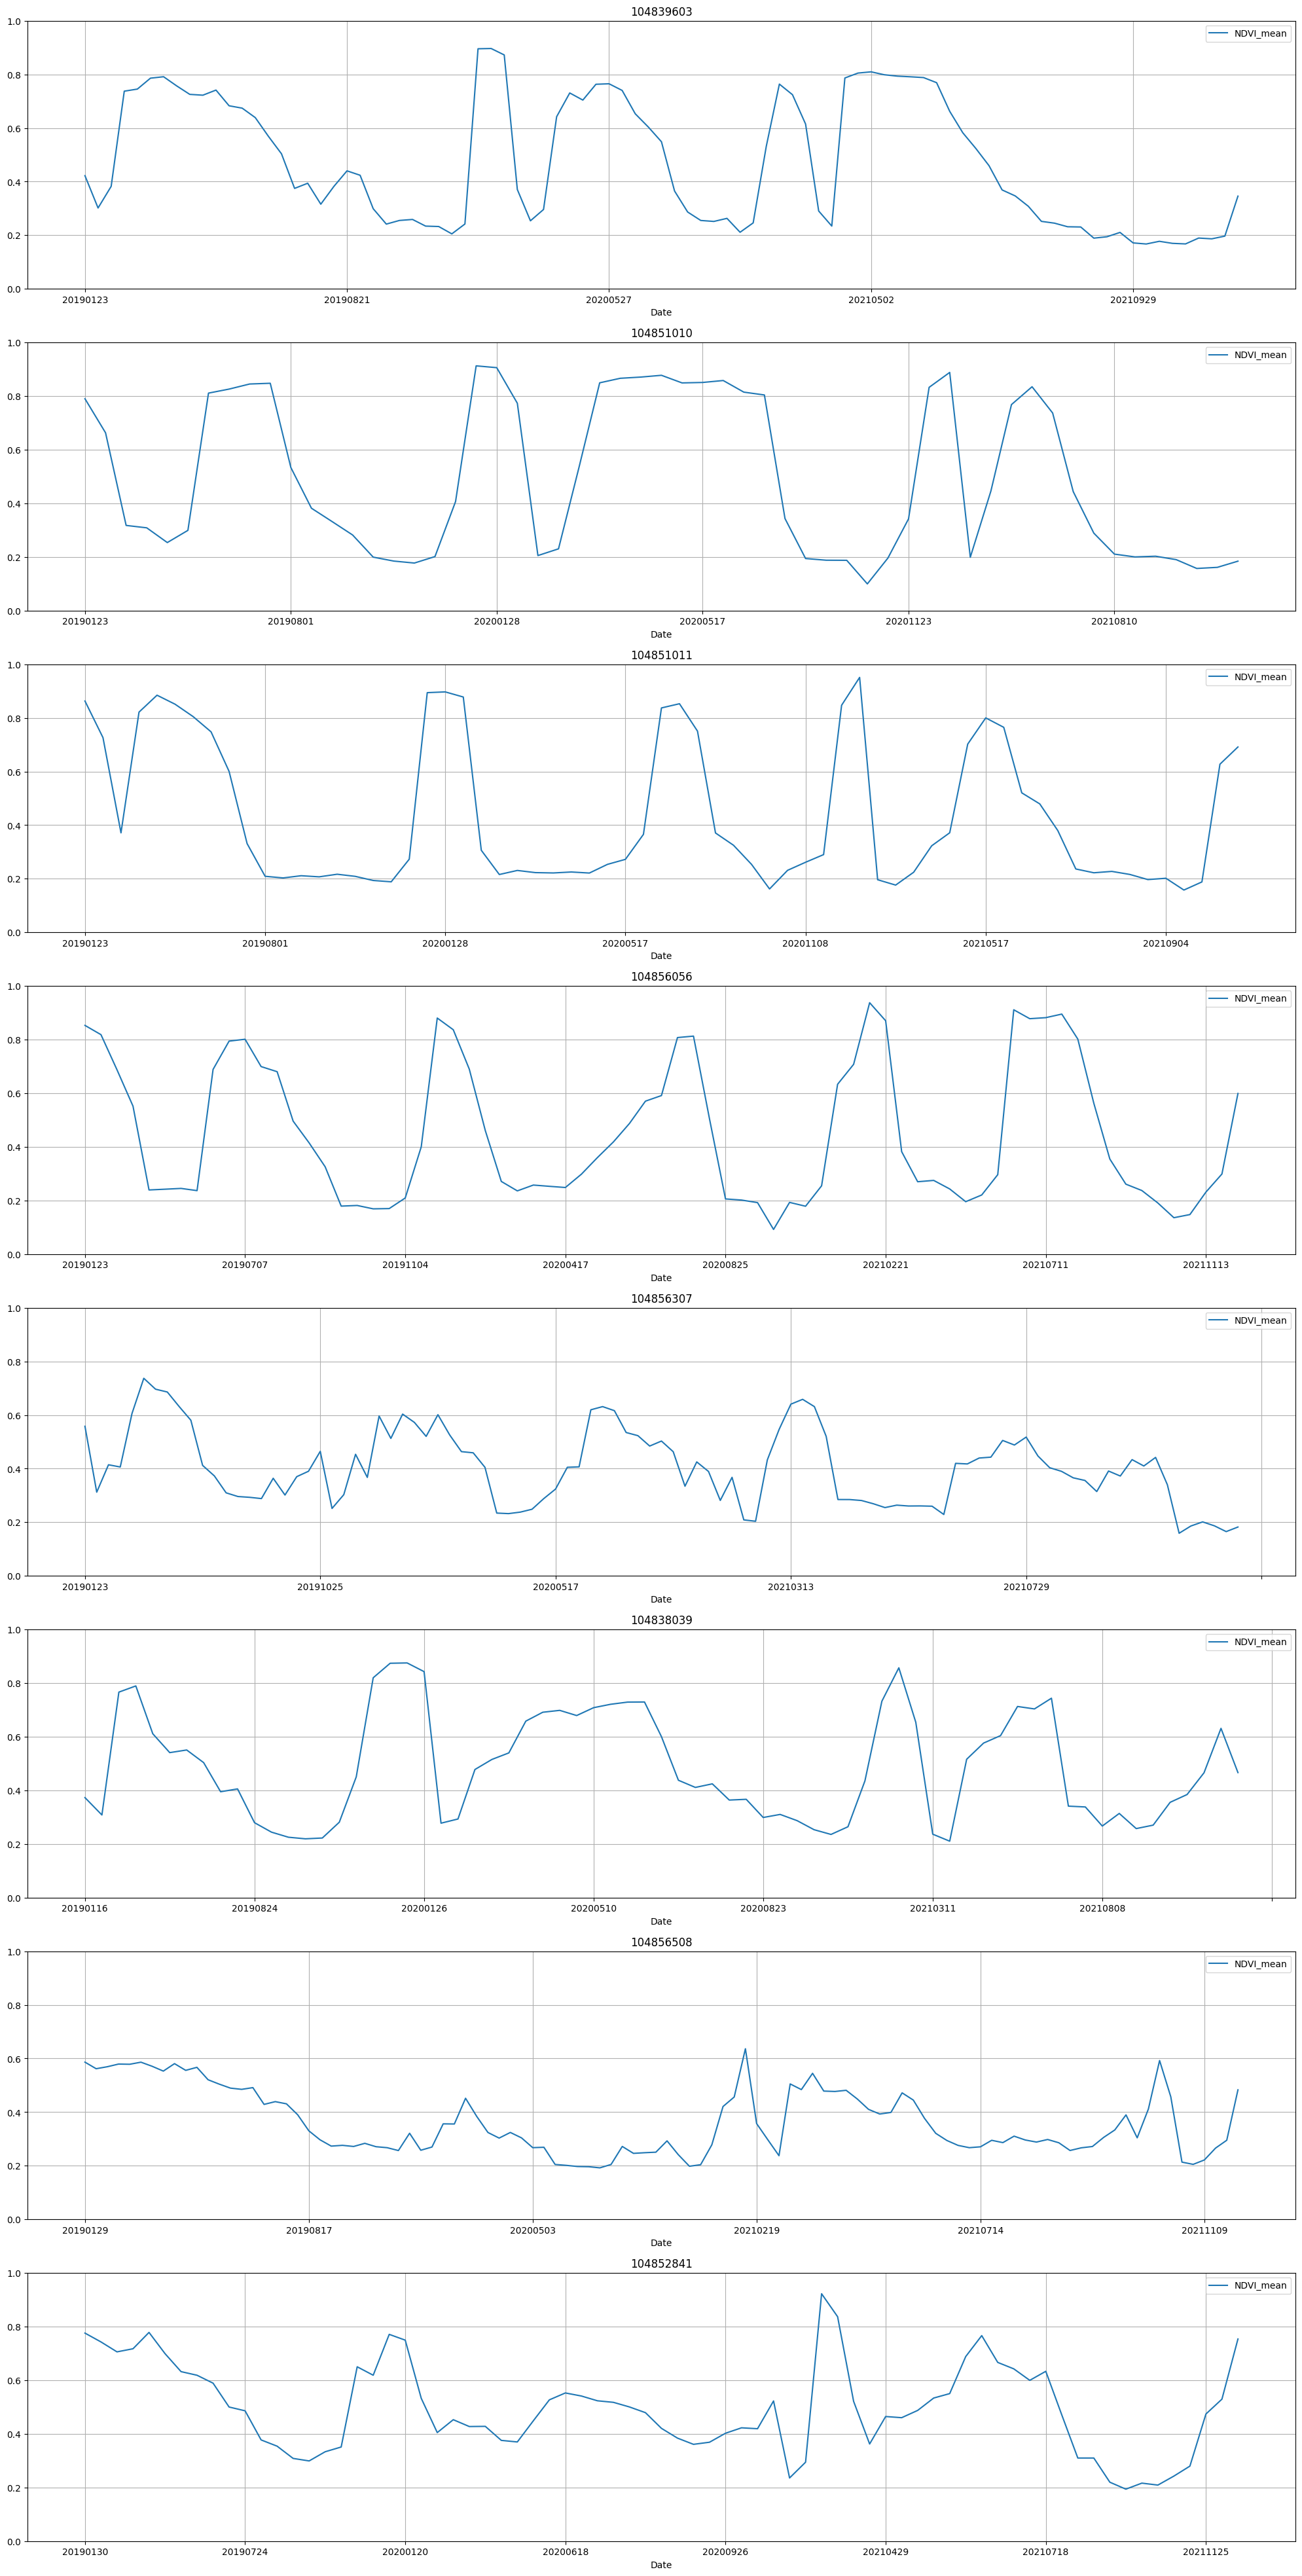

In [16]:
NDVI_plot(df,sfd_ids,save=True)